# Training DP-MLP to solve Sparse Parity

This setup involves 30 bits as input and 30 neurons in the hidden layer of the MLP.

Differential Privacy is applied but without fine-tuning of hyperparameters, the purpose of this code is to learn the implementation of DP in Pytorch without considering privacy guarantees.

C:\Users\santi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\santi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch [50/500], Loss: 1.0457, Train Acc: 0.6080, Test Acc: 0.4933
Epoch [100/500], Loss: 0.5849, Train Acc: 0.6950, Test Acc: 0.5480
Epoch [150/500], Loss: 0.5321, Train Acc: 0.8290, Test Acc: 0.6653
Epoch [200/500], Loss: 0.4641, Train Acc: 0.8960, Test Acc: 0.7433
Epoch [250/500], Loss: 0.3254, Train Acc: 0.9380, Test Acc: 0.8133
Epoch [300/500], Loss: 0.0039, Train Acc: 0.9940, Test Acc: 0.9613
Llega a Accuracy 1 en epoch  308
Llega a Accuracy 1 en epoch  309
Llega a Accuracy 1 en epoch  310
Llega a Accuracy 1 en epoch  311
Llega a Accuracy 1 en epoch  312
Llega a Accuracy 1 en epoch  313
Llega a Accuracy 1 en epoch  314
Llega a Accuracy 1 en epoch  315
Llega a Accuracy 1 en epoch  316
Llega a Accuracy 1 en epoch  317
Llega a Accuracy 1 en epoch  318
Llega a Accuracy 1 en epoch  319
Llega a Accuracy 1 en epoch  320
Llega a Accuracy 1 en epoch  321
Llega a Accuracy 1 en epoch  322
Llega a Accuracy 1 en epoch  323
Llega a Accuracy 1 en epoch  324
Llega a Accuracy 1 en epoch  325
Llega

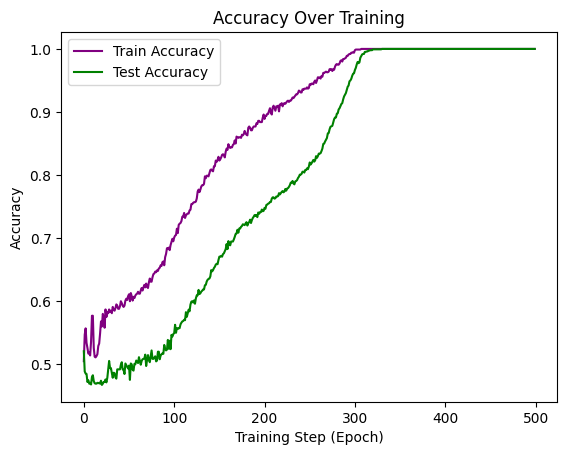

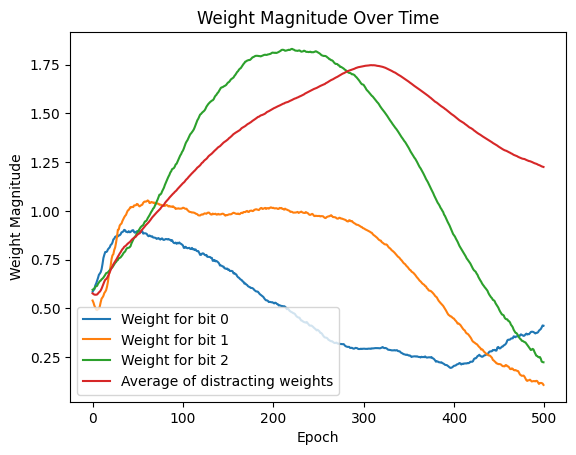

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from opacus import PrivacyEngine


torch.manual_seed(42)

train_size = 1000        
test_size = 1500        
l2_lambda = 1e-4  # Weight decay
noise_multiplier = 0.0084672234855   # DP Hiperparameters
gradientClipping = 0.3  # DP Hiperparameters
epochs = 500
batch_size = 32


unique_binary_strings = set()
while len(unique_binary_strings) < train_size + test_size:
    binary_string = tuple(np.random.randint(2, size=30))
    unique_binary_strings.add(binary_string)

inputs = np.array(list(unique_binary_strings), dtype=np.float32)
outputs = np.sum(inputs[:, :3], axis=-1) % 2  


ones_column = np.ones((inputs.shape[0], 1), dtype=np.float32)
inputs = np.concatenate((inputs, ones_column), axis=1)

indices = np.random.permutation(len(inputs))
X_train, y_train = inputs[indices[:train_size]], outputs[indices[:train_size]]
X_eval, y_eval = inputs[indices[train_size:]], outputs[indices[train_size:]]

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train).view(-1, 1))
eval_dataset = TensorDataset(torch.tensor(X_eval), torch.tensor(y_eval).view(-1, 1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(31, 30)  
        self.fc2 = nn.Linear(30, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

model = MLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), weight_decay=l2_lambda)

# Attach Privacy Engine
privacy_engine = PrivacyEngine()
model, optimizer, train_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=noise_multiplier,
    max_grad_norm=gradientClipping,
)


train_accuracies = []
test_accuracies = []
weights_over_time = []

for epoch in range(epochs):
    model.train()
    
    for inputs_batch, targets_batch in train_loader:
        optimizer.zero_grad()
        

        outputs_train = model(inputs_batch)
        loss = criterion(outputs_train, targets_batch)
        

        loss.backward()
        optimizer.step()


    with torch.no_grad():
        outputs_train_full = model(torch.tensor(X_train))
        train_accuracy = ((outputs_train_full > 0.5).float() == torch.tensor(y_train).view(-1, 1)).float().mean().item()
        train_accuracies.append(train_accuracy)


    model.eval()
    outputs_eval = model(torch.tensor(X_eval))
    test_accuracy = ((outputs_eval > 0.5).float() == torch.tensor(y_eval).view(-1, 1)).float().mean().item()
    test_accuracies.append(test_accuracy)

    # Track weights of the first layer
    weights_over_time.append(model.fc1.weight.data.clone().cpu().numpy())

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")


print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


plt.plot(train_accuracies, label='Train Accuracy', color='purple')
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.title('Accuracy Over Training')
plt.xlabel('Training Step (Epoch)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


weights_over_time = np.array(weights_over_time)
for i in range(3):
    plt.plot(np.linalg.norm(weights_over_time[:, i, :], axis=-1), label=f'Weight for bit {i}')
plt.plot(np.linalg.norm(weights_over_time[:, 3:, :], axis=-1).mean(axis=1), label='Average of distracting weights')
plt.title('Weight Magnitude Over Time')
plt.xlabel('Epoch')
plt.ylabel('Weight Magnitude')
plt.legend()
plt.show()
